In [87]:

from bs4 import BeautifulSoup
import sqlite3
import requests
import pandas as pd
from random import randint
import time
from time import sleep
from typing import List
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model, metrics, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, f1_score

In [2]:
def sleepms(milliseconds: int):
    seconds = 0.001 * milliseconds
    sleep(seconds)
    
def random_wait():
    start = time.time()
    sleepms(randint(1, 350))

def getFakeUser():
    return {"User-Agent":"PostmanRuntime/7.29.0"}


def getRetHeaders():
    url='https://www.ret.co.il/m/91935/specs'
    page = requests.get(url, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    product=soup.find('div',class_='single-product-tab')
    data=product.findAll('ul','list-group list-group-horizontal')
    myheaders= ['מחיר מינימלי','מחיר מקסימלי']
    for alldata in data:
        myheaders.append(alldata.find('span',class_='text-dark font-weight-bold').text.strip())
    return myheaders


def getUrl(url):
    page = requests.get(url, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    MainClass=soup.find('ul', class_='nav nav-pills mb-2 justify-content-around justify-content-md-start col-xxl-10 offset-xxl-1 col-md-12 offset-md-0')
    ref=[]
    data=MainClass.find('a')
    technicalDataPage='https://www.ret.co.il'+data.get('href')
    return technicalDataPage

def getRetData(url):
    technicalDataPage=getUrl(url)
    page = requests.get(technicalDataPage, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    product=soup.find('div',class_='single-product-tab')
    dataLink=product.findAll('ul',class_='list-group list-group-horizontal')
    MinMaxP=MinMaxRetPrices(url)
    mydata=[MinMaxP[0],MinMaxP[1]]
    myheaders=[]
    for alldata in dataLink:
        try:
            mydata.append(alldata.find('li',class_='list-group-item col-8 rounded-0 text-600').text.strip())
        except:
             mydata.append('None')
    return mydata

def MinMaxRetPrices(url):
    page = requests.get(url, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    MainClass=soup.find('div',class_='')
    MainClass=soup.find('div',class_='card-body p-0 p-sm-3')
    price=MainClass.find('div',class_='price')
    if(price==None):
        return [None,None]
    else:
        price=price.text.strip()
        price=price.replace(',','')
        prices=price.split()
        MinPrice=prices[0]
        MaxPrice=prices[3]
        priceArray=MinPrice,MaxPrice
        return priceArray


In [3]:
def getRetToDataFrame(phonesURL):
    hrefLinks=[]
    allRetData=[]
    page = requests.get(phonesURL, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    MainClass=soup.findAll('a')
    for href in MainClass:
        if('/m/' in href.get('href')):
            hrefLinks.append('https://www.ret.co.il' + href.get('href'))
    for hrefLink in hrefLinks:
        allRetData.append(getRetData(hrefLink))
    return allRetData


In [4]:
def mainFunc(page_num_ret):
    head=getRetHeaders()
    url=f"https://www.ret.co.il/shop/cellphone?pageindex={page_num_ret}"
    data=getRetToDataFrame(url)
    df=pd.DataFrame(data,columns=head)
    return df

In [ ]:
df_ret=mainFunc(1)
for i in range(2,10):
    df_ret=df_ret.append(mainFunc(i))
    random_wait()

In [212]:
def get_headers():
    url="https://www.zap.co.il/compmodels.aspx?modelid=1142728"
    page = requests.get(url, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    All_headers=['מחיר מינימלי','מחיר מקסימלי']
    headers=soup.find_all('div',class_="detailsRow")
    for header in headers:
        All_headers.append(header.find('div',class_="detailsRowTitletxt").text.strip())
    return All_headers


In [213]:
def get_properites_from_link(url):
    All_data=[]
    All_headers=[]
    page = requests.get(url, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    headers=soup.find_all('div',class_="detailsRow")
    titles = ['מחיר מינימלי','מחיר מקסימלי']
    prices = soup.find('div','PricesTxt').findAll('span') 
    if len(prices) == 2:
        All_data = [ prices[1].text, prices[0].text ]
    elif len(prices) == 1: 
        All_data = [ prices[0].text, prices[0].text ]
    else:
        All_data = [ None,None ]
    for header in headers:
        All_headers.append(header.find('div',class_="detailsRowTitletxt").text.strip())
        All_data.append(header.find('div',class_="detailsRowTxt").text.strip())
    return All_data

In [214]:
def get_data_from_zap(phonesURL):
    hrefLinks=[]
    all_zap_Data=[]
    Main_Url="https://www.zap.co.il"
    page = requests.get(phonesURL, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    links=soup.find_all('div',class_="MoreInfo")
    for link in links:
        hrefLinks.append(Main_Url+(link.find('a')['href']))
    for link in hrefLinks:
        all_zap_Data.append(get_properites_from_link(link))
    return all_zap_Data
    

In [215]:
def get_details_from_current_page(page_num_zap):
    url="https://www.zap.co.il/models.aspx?sog=e-cellphone&pageinfo={page_num_zap}"
    data=get_data_from_zap(url)
    df=pd.DataFrame(data,columns=get_headers())
    return df


Changing all the headers in the DataFrame from Hebrew to English

In [231]:

def change_CSV_File_Headers(df):
    df.rename(columns={"פוקוס אוטומטי": "Autofocus"}, inplace=True)
    df.rename(columns={"פלאש": "Flash"}, inplace=True)
    df.rename(columns={"מצלמה": "Camera"}, inplace=True)
    df.rename(columns={"מפעיל": "operator"}, inplace=True)
    df.rename(columns={"דור": "Generation"}, inplace=True)
    df.rename(columns={"סוג רשת": "Network kind"}, inplace=True)
    df.rename(columns={"כרטיס SIM": "SIM"},inplace=True)
    df.rename(columns={"רדיו FM": "FM radio"}, inplace=True)
    df.rename(columns={"גובה": "height"}, inplace=True)
    df.rename(columns={"רוחב": "width"}, inplace=True)
    df.rename(columns={"עובי": "thickness"}, inplace=True)
    df.rename(columns={"משקל": "wheight"}, inplace=True)
    df.rename(columns={"קיבולת סוללה": "Battery capacity"}, inplace=True)
    df.rename(columns={"סוללה נשלפת": "Removable battery"}, inplace=True)
    df.rename(columns={"רמקול חיצוני": "External speaker"}, inplace=True)
    df.rename(columns={"חיבור 3.5": "connection 3.5"},inplace=True)
    df.rename(columns={"מחיר מינימלי": "Minprice"}, inplace=True)
    df.rename(columns={"מחיר מקסימלי": "Maxprice"}, inplace=True)
    df.rename(columns={"יצרן": "Brand"}, inplace=True)
    df.rename(columns={"שנת הכרזה": "Declaration year"}, inplace=True)
    df.rename(columns={"מערכת הפעלה": "Operating System"}, inplace=True)
    df.rename(columns={"סדרה": "series"}, inplace=True)
    df.rename(columns={"מבנה המכשיר": "device structure"},inplace=True)
    df.rename(columns={"ממשק הפעלה": "operating interfaceo"}, inplace=True)
    df.rename(columns={"נפח אחסון פנימי": "Internal storage volume"}, inplace=True)
    df.rename(columns={"ערכת שבבים": "chipset"}, inplace=True)
    df.rename(columns={"צבעים": "colors"}, inplace=True)
    df.rename(columns={"טלפון כשר": "kosher phone"}, inplace=True)
    df.rename(columns={"רמת קרינה (SAR)": "radiation level"}, inplace=True)
    df.rename(columns={"טלפון למבוגרים": "Phone for adults"}, inplace=True)
    df.rename(columns={"מאיץ גרפי": "Graphics accelerator"}, inplace=True)
    df.rename(columns={"מהירות מעבד": "CPU speed"},inplace=True)
    df.rename(columns={"עמידות במים": "Water resistance"}, inplace=True)
    df.rename(columns={"קורא טביעת אצבע": "Fingerprint reader"},inplace=True)
    df.rename(columns={"גודל מסך": "screen size"}, inplace=True)
    df.rename(columns={"סוג מסך": "screen type"}, inplace=True)
    df.rename(columns={"קצב רענון": "refresh rate"}, inplace=True)
    df.rename(columns={"צפיפות פיקסלים": "Pixel density"}, inplace=True)
    df.rename(columns={"מפתח צמצם": "Aperture key"}, inplace=True)
    df.rename(columns={"מעבד": "Processor"}, inplace=True)
    df.rename(columns={"רזולוציה": "resolution"},inplace=True)
    df.rename(columns={"כרטיס זיכרון":"Memory Card"}, inplace=True)
    df.rename(columns={"זיכרון RAM": "RAM memory"}, inplace=True)
    df.rename(columns={"וידאו": "video"}, inplace=True)
    df.rename(columns={"קיבולת הסוללה": "battery capacity"}, inplace=True)
    df.rename(columns={"מספר ליבות": "number of cores"}, inplace=True)
    df.rename(columns={"מצלמה קדמית": "front camera"}, inplace=True)
    df.rename(columns={"טעינה אלחוטית": "wireless charging"}, inplace=True)
    df.to_csv("PhonesDF.csv",index=False)


In [ ]:
df_zap=get_details_from_current_page(1)
for i in range(2,21):
    df_zap=df_zap.append(get_details_from_current_page(i))
    random_wait()

Saving the first DataFrame before cleaning

In [5]:
def SaveDataFrame(df):
    df=df_zap.append(df_ret)
    df.to_csv('PhonesDF.csv',header=True)
    df=pd.read_csv('PhonesDF.csv')
    change_CSV_File_Headers(df)
    df=pd.read_csv('PhonesDF.csv')
    df


Function to clean all the Data Frame None price columns

In [88]:
def CleanTheDF(df):
    df=df.drop_duplicates()
    df.dropna(axis=0, how='all')# if all the values are None remove this row
    df=df.dropna(subset=['Minprice','Maxprice'],how ='all')
    df.drop(columns=['Unnamed: 0'],axis=1,inplace=True)
    df.to_csv('SmallPhonesDF.csv')
    return df
    

In [89]:
df=pd.read_csv('PhonesDF.csv')
Smalldf=CleanTheDF(df)
Smalldf["SIM"]

0                    eSIM
1          SIM אחד , eSIM
2      Dual SIM אופציונלי
3      Dual SIM אופציונלי
4      Dual SIM אופציונלי
5                Dual SIM
6          SIM אחד , eSIM
7      Dual SIM אופציונלי
8            יעודכן בקרוב
9      Dual SIM אופציונלי
10     Dual SIM אופציונלי
11                   eSIM
12     Dual SIM אופציונלי
13               Dual SIM
14               Dual SIM
15     Dual SIM אופציונלי
16               Dual SIM
17     Dual SIM אופציונלי
18         SIM אחד , eSIM
19     Dual SIM אופציונלי
20         SIM אחד , eSIM
21         SIM אחד , eSIM
22                   eSIM
23     Dual SIM אופציונלי
33     Dual SIM אופציונלי
48                   eSIM
101              Dual SIM
107                  eSIM
113    Dual SIM אופציונלי
480                   NaN
481                   NaN
482                   NaN
483                   NaN
484                   NaN
485                   NaN
486                   NaN
487                   NaN
488                   NaN
489         

Cleaning and converting to Numeric

In [90]:
def cleaning_to_numeric(df):
    df['radiation level']=pd.to_numeric(df['radiation level'].str.replace('W/kg','').str.strip(),errors='coerce')
    df['height']=pd.to_numeric(df['height'].str.replace('מ"מ','').str.strip(),errors='coerce')
    df['Internal storage volume']=df['Internal storage volume'].apply(lambda x: x.removesuffix('GB') if x else None)
    df['Internal storage volume']=df['Internal storage volume'].apply(lambda x: x.removesuffix('1TB') if x else None)
    # df['Internal storage volume']=pd.to_numeric(df['Internal storage volume'].str.replace('GB','').str.replace('1TB','1000').str.strip())
    df['RAM memory']=pd.to_numeric(df['RAM memory'].str.replace('GB','').str.strip(),errors='coerce')
    df['width']=pd.to_numeric(df['width'].str.replace('מ"מ','').str.strip(),errors='coerce')
    df['thickness']=pd.to_numeric(df['thickness'].str.replace('מ"מ','').str.strip(),errors='coerce')
    df['wheight']=pd.to_numeric(df['wheight'].str.replace('גרם','').str.strip(),errors='coerce')
    df['refresh rate']=pd.to_numeric(df['refresh rate'].str.replace('Hz','').str.strip(),errors='coerce')
    df['Pixel density']=pd.to_numeric(df['Pixel density'].str.replace('ppi','').str.strip(),errors='coerce')
    df['number of cores']=df['number of cores'].apply(lambda x: x.removesuffix(' ליבות') if x else None)
    df['screen size']=pd.to_numeric(df['screen size'].str.replace('אינטש','').str.strip(),errors='coerce')
    df['Network kind']=pd.to_numeric(df['Network kind'].str.replace('G','').str.strip(),errors='coerce')
    df['front camera']=pd.to_numeric(df['front camera'].str.replace('מגה פיקסל','').str.strip(),errors='coerce')
    df['Flash']=pd.to_numeric(df['Flash'].str.replace('לדים','').str.strip(),errors='coerce')
    df['resolution']=df['resolution'].apply(lambda x: x.removesuffix(' פיקסלים'))
    df['Camera']=df['Camera'].apply(lambda x: x.removesuffix(' מגה פיקסל') if x else None)
    df['Camera']=df['Camera'].apply(lambda x: x.removesuffix(' מגה פיקסלים') if x else None)
    df['Camera']=df['Camera'].apply(lambda x: x.removesuffix(' צגה פיקסל') if x else None)
    df['Camera']=df['Camera'].apply(lambda x: x.removesuffix(' גה פיקסל') if x else None)
    df['Camera']=pd.to_numeric(df['Camera'],errors='coerce')
    df['CPU speed']=df['CPU speed'].apply(lambda x: x.split()[0] if x else None)
    df['CPU speed']=pd.to_numeric(df['CPU speed'],errors='coerce')
    df['battery capacity']=df['battery capacity'].apply(lambda x: x.removesuffix(' mAh') if x else None)
    df['battery capacity']=df['battery capacity'].str.replace(',','')
    df['Minprice']=pd.to_numeric(df['Minprice'].str.replace(',','').str.strip(),errors='coerce')
    df['Maxprice']=pd.to_numeric(df['Maxprice'].str.replace(',','').str.strip(),errors='coerce')
    return df



In [99]:

df_WithNone = Smalldf.copy()
for col in df_WithNone:
    df_WithNone.loc[(df_WithNone[col] == 'לא זמין') |(df_WithNone[col] == 'יעודכן בקרוב'),col]=None
df_WithNone=cleaning_to_numeric(df_WithNone)
df_WithNone["Autofocus"] =  np.where(df_WithNone['Autofocus']  == "כולל" , 1 , 0)
df_WithNone["connection 3.5"] =  np.where(df_WithNone['connection 3.5']  == "ללא" , 0 , 1)
df_WithNone["Dual-SIM"] =  np.where(df_WithNone['Dual-SIM']  == "ללא" , 0 , 1)
df_WithNone["Memory Card"] =  np.where(df_WithNone['Memory Card']  == "ללא" , 0 , 1)
df_WithNone["Fingerprint reader"] =  np.where(df_WithNone['Fingerprint reader']  == "ללא" , 0 , 1)
df_WithNone["WiFi"] =  np.where(df_WithNone['WiFi']  == "כולל" , 1 , 0)
df_WithNone["IR"] =  np.where(df_WithNone['IR']  == "לא כולל" , 0 , 1)
df_WithNone["GPS"] =  np.where(df_WithNone['GPS']  == "כולל" , 1 , 0)
df_WithNone["NFC"] =  np.where(df_WithNone['NFC']  == "כולל" , 1 , 0)
df_WithNone['Smartphone'] =  np.where(df_WithNone['Smartphone']  == 'סמארטפון' , 1 , 0)
df_WithNone["FM radio"] =  np.where(df_WithNone['FM radio']  == "ללא רדיו" , 0 , 1)
df_WithNone["Removable battery"] =  np.where(df_WithNone['Removable battery']  == "לא" , 0 , 1)
df_WithNone["wireless charging"] =  np.where(df_WithNone['wireless charging']  == "כולל" , 1 , 0)
df_WithNone["External speaker"] =  np.where(df_WithNone['External speaker']  == "ללא" , 0 , 1)
df_WithNone["kosher phone"] =  np.where(df_WithNone['kosher phone']  == "טלפון כשר" , 1, 0)
df_WithNone["colors"] = np.where( df_WithNone['colors']!= None, 1, 0)
df_WithNone["Phone for adults"] = np.where(df_WithNone['Phone for adults']== "טלפון למבוגרים", 1, 0)
df_WithNone["operating interfaceo"] = np.where( df_WithNone['operating interfaceo']== "מסך מגע", 1, 0)

for i in df_WithNone.index:
    try:
        df_WithNone['number of cores'][i]=eval(df_WithNone['number of cores'][i])
    except:
        continue
for i in df_WithNone.index:
    try:
        df_WithNone['resolution'][i]=eval(df_WithNone['resolution'][i].replace('x','*'))
    except: 
        if df_WithNone['resolution'][i]!= None:
            a = df_WithNone['resolution'][i].split('x')
            b = a[1].split('\u200f')
            df_WithNone['resolution'][i]=(int(a[0])*int(b[0]))
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
for i in df_WithNone.index:
    if df_WithNone['Internal storage volume'][i]!='None':
        df_WithNone['Internal storage volume'][i]=int(df_WithNone['Internal storage volume'][i])
    else:
        df_WithNone['Internal storage volume'][i]=None
df_WithNone['resolution']=pd.to_numeric(df_WithNone['resolution']) 
df_WithNone['resolution']

C:\Users\david\AppData\Local\Temp\ipykernel_1380\1739880114.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_WithNone['number of cores'][i]=eval(df_WithNone['number of cores'][i])
C:\Users\david\AppData\Local\Temp\ipykernel_1380\1739880114.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_WithNone['resolution'][i]=eval(df_WithNone['resolution'][i].replace('x','*'))
C:\Users\david\AppData\Local\Temp\ipykernel_1380\1739880114.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

0      4446720.0
1      2962440.0
2      3606840.0
3      2592000.0
4      2962440.0
5      2527200.0
6      2962440.0
7      2592000.0
8      2592000.0
9      2592000.0
10     3013524.0
11     2527200.0
12     3013524.0
13     2592000.0
14     2592000.0
15     2600640.0
16     2592000.0
17     2527200.0
18     3566952.0
19     3308640.0
20     2962440.0
21     1483776.0
22     2592000.0
23     3606840.0
33     2592000.0
48     4446720.0
101    2527200.0
107    2527200.0
113    2527200.0
480    2962440.0
481    1483776.0
482    4608000.0
483    2592000.0
484    3566952.0
485    2962440.0
486    2592000.0
487    2592000.0
488    3566952.0
489    2592000.0
490    2592000.0
491    2592000.0
492    2592000.0
493    1152000.0
494    4446720.0
495    2592000.0
496    2527200.0
497    4377600.0
498    2592000.0
499    3338496.0
500    4377600.0
501    2962440.0
502    2851200.0
503    2527200.0
504    2592000.0
505    1152000.0
506    1000500.0
507    2592000.0
508    4446720.0
509    4608000

After using the pd.to_numeric all the values that werent changed got changed into NAN values and we also saw that we good 'None' values as a string insted of None this rows change them back to None

In [100]:
df_WithNone = df_WithNone.replace({np.nan:None})
df_WithNone=df_WithNone.replace('None', None)
df_WithNone['width']=pd.to_numeric(df['width'],errors='coerce')
df_WithNone['height']=pd.to_numeric(df['width'],errors='coerce')
df_WithNone['wheight']=pd.to_numeric(df['width'],errors='coerce')
df_WithNone['Declaration year']=pd.to_numeric(df['Declaration year'],errors='coerce')
df_WithNone['number of cores']=pd.to_numeric(df_WithNone['number of cores'],errors='coerce')
df_WithNone['battery capacity']

0      5000
1      None
2      None
3      5000
4      None
5      3700
6      None
7      4500
8      5000
9      5000
10     None
11     4500
12     None
13     5000
14     5000
15     5000
16     4500
17     3700
18     None
19     5000
20     None
21     3110
22     4410
23     None
33     5000
48     5000
101    3700
107    4500
113    3700
480    None
481    3110
482    5000
483    4000
484    None
485    None
486    5000
487    5160
488    None
489    4500
490    4500
491    5000
492    4520
493    5000
494    4500
495    4500
496    2227
497    4100
498    4800
499    3969
500    3400
501    None
502    3300
503    4080
504    4500
505    5000
506    1821
507    5000
508    4500
509    5000
510    6000
511    3100
512    2942
513    3110
514    4300
515    3046
516    2815
517    2227
518    4600
519    2815
520    5160
521    5020
522    4500
523    3046
524    4300
525    1821
526    4500
527    4500
528    5000
529    3140
530    1821
531    3500
532    4250
533    4000
534 

In [101]:
list_describe=df_WithNone.describe().columns
all_cols=df_WithNone.columns
listNotInDescribe=[]
for col in all_cols:
    if(col not in list_describe):
        listNotInDescribe.append(col)
listNotInDescribe


['Brand',
 'Operating System',
 'device structure',
 'series',
 'radiation level',
 'Internal storage volume',
 'chipset',
 'Processor',
 'CPU speed',
 'Graphics accelerator',
 'RAM memory',
 'Water resistance',
 'screen size',
 'screen type',
 'resolution',
 'Pixel density',
 'refresh rate',
 'SIM',
 'Network kind',
 'Generation',
 'operator',
 'Bluetooth',
 'Camera',
 'Flash',
 'Aperture key',
 'video',
 'front camera',
 'thickness',
 'battery capacity']

its look that we have a lot of cols that not in our describe so we will want to try to fillna

In [96]:
df_WithNone.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 429 entries, 0 to 883
Data columns (total 54 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Minprice                 429 non-null    int64 
 1   Maxprice                 429 non-null    int64 
 2   Brand                    414 non-null    object
 3   Operating System         389 non-null    object
 4   Declaration year         310 non-null    object
 5   device structure         412 non-null    object
 6   series                   250 non-null    object
 7   Smartphone               414 non-null    object
 8   radiation level          127 non-null    object
 9   operating interfaceo     413 non-null    object
 10  kosher phone             429 non-null    int32 
 11  colors                   429 non-null    int32 
 12  Phone for adults         29 non-null     object
 13  Internal storage volume  388 non-null    object
 14  chipset                  300 non-null    o

In [112]:
df_WithNone['CPU speed']

0      1700.0
1        None
2        None
3      1800.0
4      1820.0
        ...  
879    1900.0
880    1800.0
881      None
882    2000.0
883    2000.0
Name: CPU speed, Length: 429, dtype: object

we will want to drop the unnecessary cols 

In [134]:
df_WithNone=df_WithNone.drop(['radiation level','Phone for adults'
,'wireless charging','Aperture key','device structure','Declaration year','SIM'],axis=1)

In [135]:
df_WithNone.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 429 entries, 0 to 883
Data columns (total 47 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Minprice                 429 non-null    int64  
 1   Maxprice                 429 non-null    int64  
 2   Brand                    429 non-null    object 
 3   Operating System         429 non-null    object 
 4   series                   429 non-null    object 
 5   Smartphone               429 non-null    int32  
 6   operating interfaceo     429 non-null    int32  
 7   kosher phone             429 non-null    int32  
 8   colors                   429 non-null    int32  
 9   Internal storage volume  388 non-null    float64
 10  chipset                  428 non-null    object 
 11  Processor                419 non-null    object 
 12  number of cores          307 non-null    object 
 13  CPU speed                273 non-null    float64
 14  Graphics accelerator     4

now we want to fillna some nan like battery

108
7850


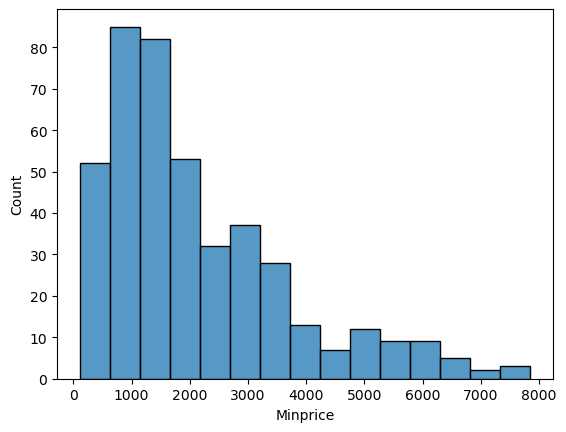

In [150]:
print(df_WithNone["Minprice"].min())
print(df_WithNone['Minprice'].max())

sns.histplot(df_WithNone['Minprice'])
plt.show()

its like we will know which what to fill the nan vals

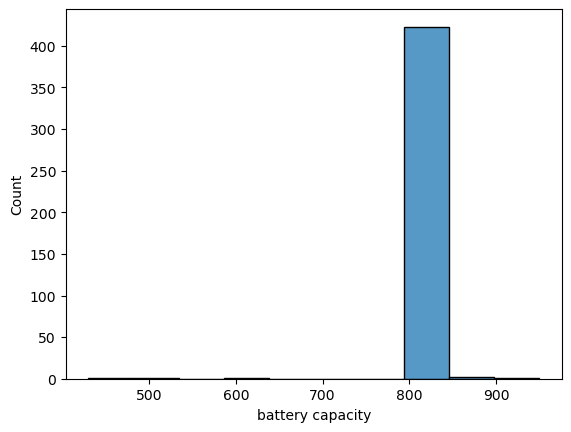

In [104]:
most_freq = df_WithNone['battery capacity'].mode()[0]
df_WithNone['battery capacity'] = df_WithNone['battery capacity'].fillna(most_freq)
sns.histplot(df_WithNone['battery capacity'])
plt.show()

We decided to combain the MinPrice and MaxPrice into an avarage price.

In [10]:
dfUnionPrice=df_WithNone.copy()
dfUnionPrice['Price']=(dfUnionPrice['Minprice'] + dfUnionPrice['Maxprice'])/2
dfUnionPrice=dfUnionPrice.drop(['Minprice','Maxprice'],axis=1)
dfUnionPrice.describe()

,kosher phone,colors,Memory Card,Fingerprint reader,WiFi,IR,GPS,NFC,Autofocus,connection 3.5,External speaker,FM radio,Removable battery,wireless charging,Dual-SIM,Price
count,429.000000,429.0,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,0.020979,1.0,0.568765,0.867133,0.916084,0.571096,0.909091,0.587413,0.482517,0.510490,0.995338,0.426573,0.104895,0.370629,0.752914,1894.544289
std,0.143481,0.0,0.495827,0.339827,0.277586,0.495497,0.287815,0.492875,0.500278,0.500474,0.068199,0.495157,0.306776,0.483537,0.431821,1399.096567
min,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,108.000000
25%,0.000000,1.0,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,849.500000
50%,0.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1494.000000
75%,0.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,2563.000000
max,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7850.000000
